<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Supplemental Notebook: Extracting morphological features</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<p>Analyzing neuron morphology data begins with accessing it--and understanding how the data is structured. This notebook reviews an example of how to load, examine, and visualize a neuron skeleton in both 2D and 3D. 
    
<p> Then, we will introduce some tools for accessing different features within the skeleton data. This is also a reference notebook you may come back to for specific tools to answer the scientific questions. 
    
<p>We will quantify the:    
<ul>
<li> path-length of axons and dendrites
<li> distribution of branch lengths
<li> relationship between axon and dendrite, re: branch number and path-length.
</ul>
    
    
</div>

In [1]:
#all imports
import pandas as pd
import numpy as np
from os.path import join as pjoin
import cloudvolume
from meshparty import skeleton
import skeleton_plot as skelplot

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("..") # to access utils folder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This cell sets up a variable called `data_root` that you should use in any code below to access the dataset in question (e.g. paths to manifest files for the SDK should be made relative to this variable).
</div>

In [2]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/anatomy"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/anatomy"
elif ('amzn2' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/anatomy"

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
 
<h2> Load a precomputed skeleton </h2>

<p> Previously we viewed the Electron Microscopy (EM) and Light Microscopy (LM) reconstructions seperately. However, both datasets exist as part of the common coordinate framework (CFF). 

<p> You can see both example cells rendered in CCF in <a ref="https://spelunker.cave-explorer.org/#!middleauth+https://global.daf-apis.com/nglstate/api/v1/4754960374824960">Neuroglancer</a>.
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:</b>  Choose your own adventure: use either the EM or LM data path from the previous notebook. Return here later to select the other data type.
    
<p>Note: we use a convenient utility function here to load the precomputed skeleton and format it as a meshwork skeleton. This is the same operation as in Day 1's <i>Notebook 0</i> .
</div>

In [3]:
#Answer 1
from utils.skeleton_loading_utils import load_em_skeleton_as_meshwork

skeleton_id = 864691135591041291
sk, conversion_factor = load_em_skeleton_as_meshwork(skeleton_id, data_root)

In [4]:
# #Answer 2 
# from utils.skeleton_loading_utils import load_lm_skeleton_as_meshwork

# skeleton_id = 14
# sk, conversion_factor = load_lm_skeleton_as_meshwork(skeleton_id, data_root)

(479016.0, 1348952.0, 1000984.0, 290944.0)

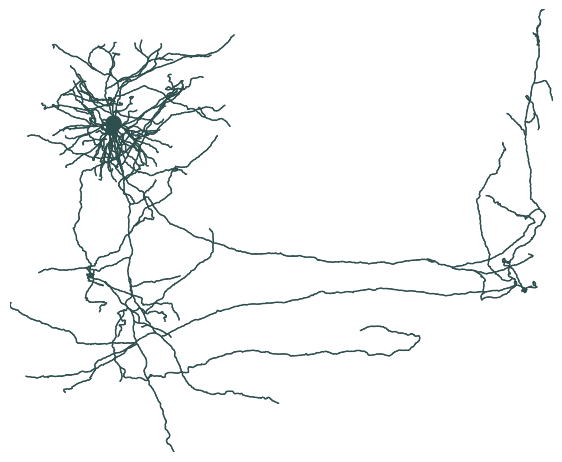

In [5]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    plot_soma = True,
    invert_y = True,
    x="x",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2> Calculate Basic Morphology features of the skeleton </h2>

<p> We will be using the <a href="https://github.com/CAVEconnectome/MeshParty/">MeshParty</a> toolbox which simplifies the process of extracting features like branches and endpoints, and calculating <b>path-lengths</b>--the distance in space traversed by the neurites.
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1.1: Vertices and Neighborhoods ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Vertices </h4>
    
<p> Each vertex is represented by an integer and has an xyz coordinate associated to it. The neighborhood of a node includes all nodes that are directly connected to it by a single edge. Here is an example were we sample a random node and list its neighbors. 
</div>

In [6]:
# Vertices
print(f"There are {len(sk.vertices)} vertices in this neuron")

There are 9154 vertices in this neuron


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Branch Points </h4>

<p> Vertices with three or more neighbors
    
</div>

In [7]:
# Branch points
print("Branch points are at the following vertices: \n",sk.branch_points)

Branch points are at the following vertices: 
 [ 522  738 1115 1256 1263 1428 1493 1523 1535 1540 1632 1866 1878 1902
 1935 1951 1996 2030 2043 2074 2104 2170 2190 2243 2262 2271 2294 2304
 2384 2425 2445 2449 2484 2611 2616 2653 2687 2736 2755 2760 2775 2848
 2867 2972 3049 3057 3110 3176 3226 3302 3340 3386 3413 3423 3453 3513
 3516 3550 3558 3622 3638 3665 3688 3703 3721 3823 3972 4016 4024 4065
 4068 4096 4113 4161 4225 4285 4302 4366 4390 4466 4543 4718 4921 4959
 4985 5161 5176 5509 5518 5727 5746 5925 6800 7798 7858 7920 8463 8492
 8614 8632 8645 8755 8903 8933 9026 9057 9082 9153]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> End points </h4>
    
<p> Vertices with exactly one neighbor.
    
</div>

In [8]:
# End points
print("End points are at the following vertices: \n",sk.end_points)

End points are at the following vertices: 
 [   5   29   31   68   86  170  172  177  218  245  286  291  323  335
  366  392  419  470  516  564  638  647  881  934  950 1286 1347 1351
 1544 1562 1661 1662 1672 1682 1743 1778 1781 1811 2008 2042 2072 2096
 2168 2259 2367 2370 2373 2470 2562 2622 2623 2638 2682 2756 2757 2842
 2882 2937 3030 3073 3130 3150 3193 3296 3395 3519 3720 3864 4051 4394
 4477 4502 4611 4679 4740 4771 4776 4813 4887 5131 5198 5547 5551 5591
 5597 5618 5663 5685 5823 5870 5891 6128 6146 6171 6181 6268 6314 6352
 6400 6426 6445 6546 6709 6780 6848 6874 6967 7028 7070 7093 7289 7531
 7822 8064 8252 8266 8323 8490 8497 8745 8861 8872 8931 9012 9014 9042
 9116 9152]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Root </h4>
    
<p> Unique vertex that represents the soma. In the directed graph, a node with no parents. 
</div>

In [9]:
# Root - the point associated with the root node, which is the soma
print("Root is vertex: ", sk.root.item())

Root is vertex:  9153


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1.2: Paths and Segments ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Segments</h4>
    
<p>The path of nodes between two vertices i and j which are assumed to be a root, branch point, or endpoint.
    
</div>

In [10]:
# Segments - the branch segments
print("The number of branch segments are: \n",len(sk.segments))

The number of branch segments are: 
 236


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Path between </h4>
    
<p> The skeleton meshwork's <code>path_between()</code> function finds the <b>vertices on the path</b> between two points on the skeleton graph.
    
</div>

In [11]:
# Path-length for all neurites
nodes_between = sk.path_between(0,150) 
print("Path between the given nodes: ", nodes_between)

Path between the given nodes:  [   0    2    7    1    3    8    9   10   11   12   13   14   15   17
   16   18   19   20   21   22   23   24   25   26   27   28   33   34
   38   39   42   45   46   49   52   55   56   60   63   69   75   76
   82   83   93   92  105  114  115  121  126  133  134  139  140  149
  162  163  181  192  205  227  228  247  261  277  295  316  317  346
  369  387  409  410  437  436  438  461  462  496  497  538  539  589
  590  591  592  593  632  675  676  728  798  847  890  930  991 1050
 1126 1214 1298 1373 1441 1509 1576 1622 1674 1675 1673 1755 1754 1844
 1916 2003 2083 2156 2239 2346 2464 2463 2576 2704 2812 2925 2926 3042
 3151 3271 3270 3382 3487 3588 3589 3673 3672 3746 3826 3825 3940 4037
 4038 4138 4230 4229 4312 4390 4391 4313 4314 4231 4139 4140 4039 4040
 3941 3827 3828 3830 3748 3750 3675 3676 3677 3592 3489 3490 3385 3273
 3274 3153 3044 3045 2931 2821 2822 2711 2712 2582 2466 2467 2349 2350
 2241 2159 2085 2086 2006 2007 1918 1847 1757 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Calculate pathlength </h4>
    
<p> The skeleton meshwork's <code>path_length()</code> function calculates the <b>physical</b> distance along the path for a neuron
    
</div>

In [12]:
# Path-length for all neurites
full_pathlength = sk.path_length() / conversion_factor # Convert to nanometers
print("Path-length of the entire neuron: ", full_pathlength, ' um')

Path-length of the entire neuron:  18486.71  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Use the pathlength operation on subsets of the path as well
    
</div>

In [13]:
# Path-length for arbitrary segment
example_segment = 11
segment_pathlength = sk.path_length(sk.segments[example_segment]) / conversion_factor # Convert to nanometers 
print("Path-length of one segment: ", segment_pathlength, ' um')

Path-length of one segment:  25.2105859375  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1.3: Subgraphs ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Visualize path of one segment </h4
    
<p> Combining the skeleton plot functionality shown previously, here we overlay an example segment. </p>
    
</div>

(479016.0, 1348952.0, 1000984.0, 290944.0)

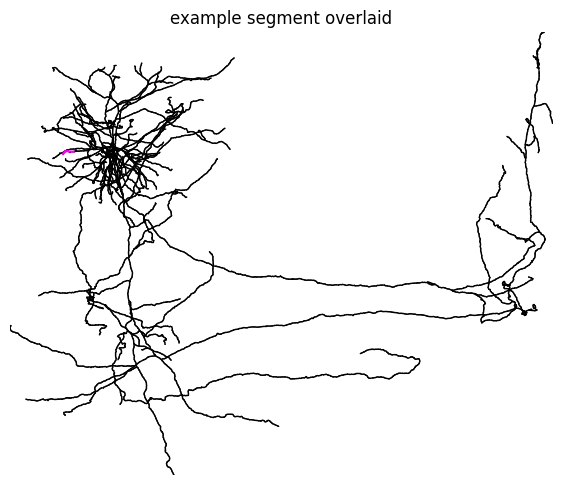

In [14]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="example segment overlaid",
    line_width=1,
    invert_y=True,
    color='k',
    x="x",
    y="y",
)

# index into the skeleton vertices with the segment
ax.plot(sk.vertices[sk.segments[example_segment]][:,0], 
        sk.vertices[sk.segments[example_segment]][:,1], 
        color='magenta')

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Using Masks to Select Parts of the Skeleton </h4>
    
<p> One of the most useful features of the skeleton meshwork's is the ability to <b>mask</b> or select only parts of the skeleton to work with at a time. The function <code>apply_mask()</code> acts on the meshwork skeleton, and will apply in place if <code>apply_mask(in_place=True)</code>. 

<p>
    
<p> <b><i>Warning</i></b>: be aware when setting a mask in place--mask operations are additive. To reset the mask completely, use <code>reset_mask(in_place=True)</code>.
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Let's select a set of nodes from example segment 11:
    
</div>

In [15]:
example_segment = 11
selected_nodes = sk.segments[example_segment]
print(selected_nodes)

[291 290 308 306 304 331 332 358 379 380 401 428 452 484]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Apply a mask to these nodes:
    
</div>

In [16]:
#reset to make sure you have the full skeleton
sk.reset_mask(in_place=True)
# Apply mask
sk_masked = sk.apply_mask(selected_nodes)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p> Check that this masked skeleton matches the pathlength calculated above
    
</div>

In [17]:
sk_masked.path_length() / conversion_factor

25.210587890625

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Selecting Axons and Dendrites </h4>
    
<p> Critically, <code>apply_mask()</code> allows us to mask a neuron according to its compartment label: axon, dendrite, soma, etc. 
    
<p> <b>Compartment label conventions</b> (from standardized swc files <a href="www.neuromorpho.org">www.neuromorpho.org</a>
<ul>
<li> 0 - undefined
<li> 1 - soma
<li> 2 - axon
<li> 3 - (basal) dendrite
<li> 4 - apical dendrite
<li> 5+ - custom
</ul>
    
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>Create a skeleton only with the dendrites and compute its path length
    
</div>

In [18]:
sk.vertex_properties['compartment']

array([2., 2., 2., ..., 2., 2., 1.], dtype=float32)

In [19]:
# Select the indices associated with the axon, and dendrites

dendrite_inds = (sk.vertex_properties['compartment']==3) | (sk.vertex_properties['compartment']==4)| (sk.vertex_properties['compartment']==1) #soma is included here to connect the dendrite graphs 

# create new skeleton that masks (selects) only the axon
sk_dendrite = sk.apply_mask(dendrite_inds)
print("Dendrite pathlength of all branches is : ", sk_dendrite.path_length() / conversion_factor, ' um')

Dendrite pathlength of all branches is :  5341.963  um


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.3.1:</b>  Create an axon skeleton and compute its path length
</div>

In [20]:
#Answer
axon_inds = sk.vertex_properties['compartment']==2
sk_axon = sk.apply_mask(axon_inds)
print("Axon pathlength is : ", sk_axon.path_length() / conversion_factor, ' um')


Axon pathlength is :  13131.338  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Selecting Dendrite Segments </h4>
    
<p> Let's look at all the segments in the dendrite graph:
    
</div>

(532366.8, 853065.2, 579152.0, 320256.0)

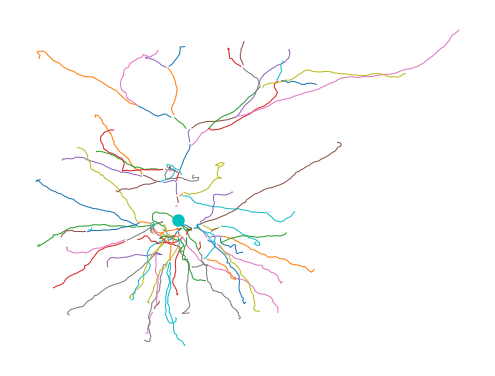

In [21]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)

for ss in range(len(sk_dendrite.segments)):
    seg = sk_dendrite.segments[ss]

    ax.plot(sk_dendrite.vertices[seg][:,0], 
            sk_dendrite.vertices[seg][:,1], linewidth=0.5)

# add soma marker
ax.plot(sk.vertices[sk.root][0], 
        sk.vertices[sk.root][1], 'oc', markersize=5)
    
ax.invert_yaxis()
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Selecting Downstream points</h4>
    
<p> Meshwork has a nifty function for subselecting points: downstream points. For a given point, downstream points are defined as points on paths from endpoints to the root which are further than the given point. For example, if the skeleton path is : A-B-C-D-E where A is the root, D and E are downstream points of C. With branching, this can be more complex. To find the downstream points from say the 30th branch point, we can do:
    
</div>

In [22]:
# Select downstream nodes from one branch point
downstream_nodes = sk.downstream_nodes(sk.branch_points[3])

(479016.0, 1348952.0, 1000984.0, 290944.0)

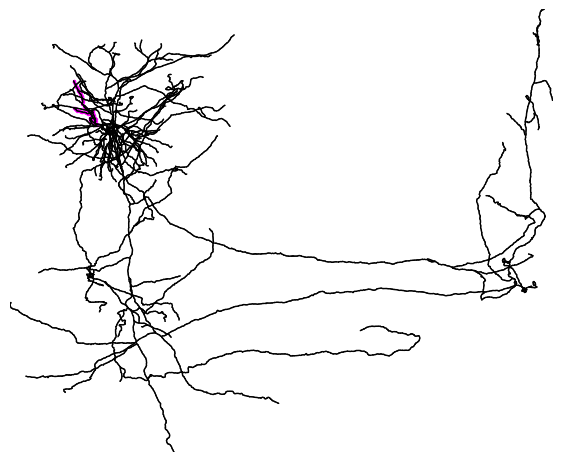

In [23]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    line_width = 1,
    color='k',
    invert_y = True,
    x="x",
    y="y",
)

# Add the downstream vertices as red points (Note: this works for x-y plot orientation; select the columns appropriate to your skeleton orientation)
ax.scatter(sk.vertices[downstream_nodes][:,0], sk.vertices[downstream_nodes][:,1], c='magenta', s=2)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1..4: Analyzing the Morphology of a Single Neuron ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
    
<h4> Distribution of branch lengths </h4>
    
    
<p> Note that each have different lengths. Let's create a histogram of all the path lengths of the segments/branches in dendrite graph
    
</div>

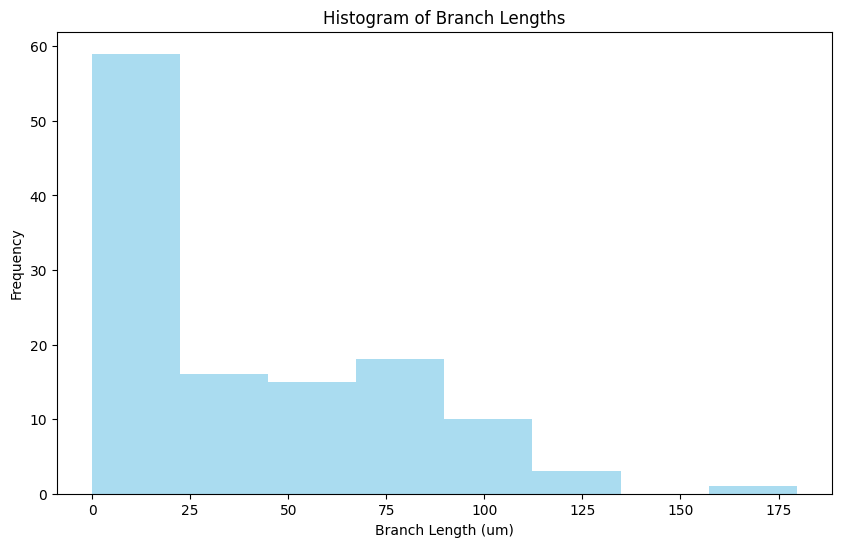

In [24]:
# find Branch lengths
branch_lengths = np.array([sk_dendrite.path_length(seg) for seg in sk_dendrite.segments]) / conversion_factor
plt.figure(figsize=(10, 6))
plt.hist(branch_lengths, bins='auto', color='skyblue', alpha=0.7)
plt.title("Histogram of Branch Lengths")
plt.xlabel("Branch Length (um)")
plt.ylabel("Frequency")
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
    
<h4> Compute longest path </h4>
    
    
<p> What is the maximum distance you could travel from tip to tip without repeating a node?
    
</div>

In [25]:
# First, find the path length for every tip (end point) to root:
end_point_df = pd.DataFrame({'end_point': sk.end_points, 
                             'dist_to_root': sk.distance_to_root[sk.end_points]})
end_point_df = end_point_df.sort_values('dist_to_root', ascending=False).reset_index(drop=True)

furthest_ind = end_point_df.iloc[0].end_point.astype(int)

# Now find the next longest point that is not on the same path
path_to_furthest = sk.path_between(furthest_ind, sk.root)

path_overlap_list = []
for ii in end_point_df.index:
    ii_path = sk.path_between(end_point_df.iloc[ii].end_point, sk.root)
    path_overlap = len(np.intersect1d(path_to_furthest, ii_path))
    path_overlap_list.append(path_overlap)
    
end_point_df['path_overlap'] =    path_overlap_list
second_furthest_ind = end_point_df.iloc[np.argmin(end_point_df.path_overlap)].end_point.astype(int)

# calculate the path between:
longest_path_indices = sk.path_between(furthest_ind, second_furthest_ind)
print("Longest pathlength between two points is : ",
      sk.path_length(longest_path_indices) / conversion_factor,
      ' um')

Longest pathlength between two points is :  2035.06975  um


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
    
<h4> Plot the longest path </h4>
    
    
<p> Tip: try changing the orientation from XZ to XY or YZ
    
</div>

(479016.0, 1348952.0, 1113880.0, 594080.0)

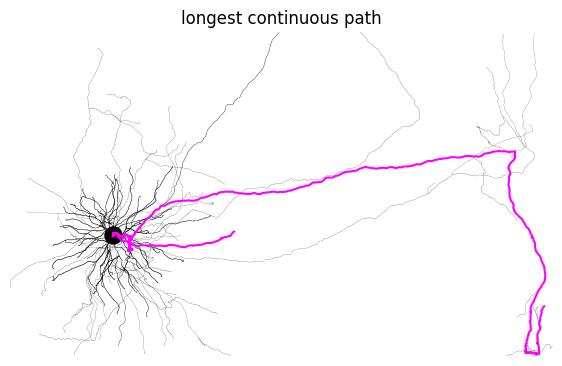

In [26]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="longest continuous path",
    line_width=1,
    plot_soma=True,
    soma_size = 150,
    pull_radius=True,
    invert_y=True,
    pull_compartment_colors=False,
    color='black',
    x="x",
    y="z",
)

# index into the skeleton vertices with the segment indices
ax.plot(sk.vertices[longest_path_indices][:,0], 
        sk.vertices[longest_path_indices][:,2], 
        color='magenta')

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h3>----- Section 1.5: AComparing the Morphology of Multiple Neurons ----- </h3>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h4> Plot the relationship of axon and dendrite pathlength </h4>
    
<p> Here we try to plot axon length vs dendrite length by selecting a random set. However, this set can be chosen based on some manual or automatic criterion for analysis. 
    
</div>

In [27]:
''' read 10 neurons '''
#For EM:
Ids = [864691134884807418, 864691134886016762, 864691134886037498, 864691134918642954,
       864691134941063523, 864691134941217635, 864691134941291363, 864691134941297763,
       864691134941299811, 864691134948652540]

# #For LM 
# Ids = [1,2,3,4,5,7,9,14,16,17]

In [28]:
'''do a scatter of axon length to dendrite length'''
ax = []
de = []

for skeleton_id in Ids:
    # For EM read precomputed
    sk, _ = load_em_skeleton_as_meshwork(skeleton_id, data_root)
    
#     # For LM
#     sk, _ = load_lm_skeleton_as_meshwork(skeleton_id, data_root)
    
    #select axon
    axon_inds = sk.vertex_properties['compartment']==2
    sk_axon = sk.apply_mask(axon_inds)
    
    #calculate, append pathlength
    ax.append(sk_axon.path_length()/conversion_factor)
    
    #select dendrite
    dendrite_inds = (sk.vertex_properties['compartment']==3) | (sk.vertex_properties['compartment']==4)| (sk.vertex_properties['compartment']==1) #soma is included here to connect the dendrite graphs 
    sk_dendrite = sk.apply_mask(dendrite_inds)
    
    #calculate, append pathlength
    de.append(sk_dendrite.path_length()/conversion_factor)    


<Axes: xlabel='dendrite length', ylabel='axon length'>

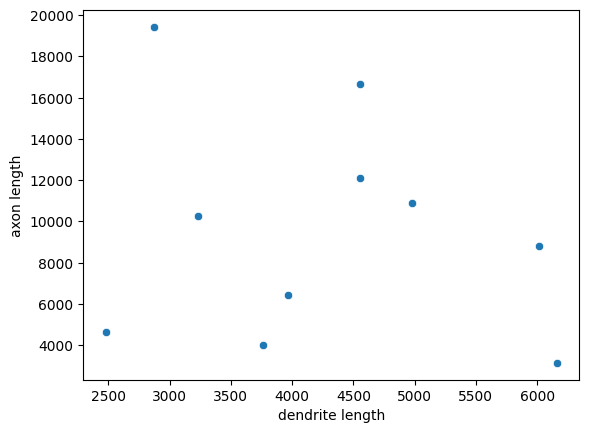

In [29]:
#plot axon vs dendrite lengths
d = {'axon length': ax, 'dendrite length': de}
dataframe = pd.DataFrame(data=d)
sns.scatterplot(data = dataframe, y ="axon length", x= "dendrite length")